In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [114]:
combined_df = pd.read_csv("../notebook/combined.csv")

In [115]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [116]:
combined_df.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,NaN,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [117]:
combined_df.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [118]:
combined_df.duplicated().sum()

np.int64(4259)

In [119]:
combined_df.drop_duplicates(inplace=True)
combined_df.reset_index(drop=True, inplace=True)

In [120]:
combined_df['County'] = combined_df.groupby('Market')['County'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [121]:
combined_df['Supply Volume'] = combined_df.groupby(['Commodity', 'Market'])['Supply Volume'].transform(lambda x: x.fillna(x.median()))

In [122]:
combined_df.isnull().sum()

Commodity            0
Classification       0
Grade                0
Sex                  0
Market               0
Wholesale            0
Retail               0
Supply Volume     9251
County               0
Date                 0
dtype: int64

In [123]:
combined_df['Supply Volume'] = combined_df.groupby('Commodity')['Supply Volume'].transform(lambda x: x.fillna(x.median()))

In [124]:
tb= combined_df.drop(columns=["Classification", "Grade", "Sex"])

In [125]:
tb.head()

,Commodity,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),Mukuyu Market,-,50.00/Kg,1500.0,Muranga,2026-02-11
1,Banana (Ripening),Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [126]:
tb.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [127]:
tb['Wholesale'] = pd.to_numeric(tb['Wholesale'].astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
tb['Retail'] = pd.to_numeric(tb['Retail'].astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')

In [128]:
tb['Price_Margin']      = tb['Retail'] - tb['Wholesale']
tb['Margin_Percentage'] = np.where(tb['Wholesale'] > 0, tb['Price_Margin'] / tb['Wholesale'] * 100, 0)

In [129]:
tb = tb[tb['Wholesale'] > 0].copy()
tb['Date'] = pd.to_datetime(tb['Date'], errors='coerce')
tb = tb.dropna(subset=['Date'])

print(tb.dtypes)
print(tb.shape)

Commodity                    object
Market                       object
Wholesale                   float64
Retail                      float64
Supply Volume               float64
County                       object
Date                 datetime64[ns]
Price_Margin                float64
Margin_Percentage           float64
dtype: object
(41690, 9)


In [130]:
print(tb.isnull().sum())

Commodity               0
Market                  0
Wholesale               0
Retail               2183
Supply Volume           0
County                  0
Date                    0
Price_Margin         2183
Margin_Percentage    2183
dtype: int64


In [131]:
tb = tb.dropna(subset=['Retail']).copy()
tb.reset_index(drop=True, inplace=True)

print(tb.isnull().sum())
print(tb.shape)

Commodity            0
Market               0
Wholesale            0
Retail               0
Supply Volume        0
County               0
Date                 0
Price_Margin         0
Margin_Percentage    0
dtype: int64
(39507, 9)


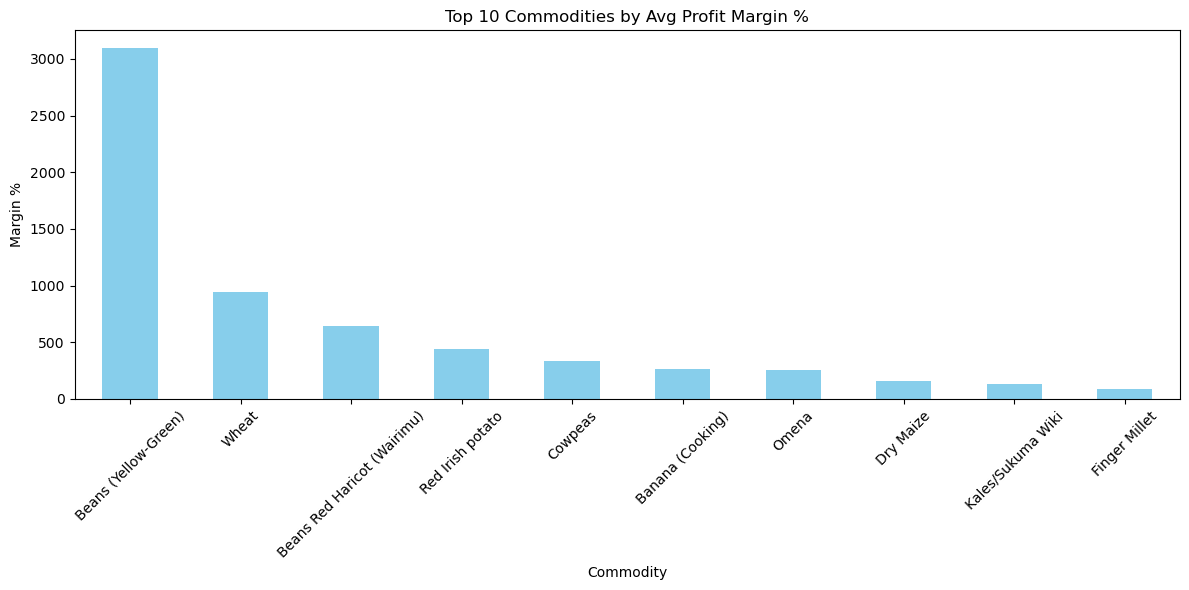

In [132]:
plt.figure(figsize=(12, 6))
tb.groupby('Commodity')['Margin_Percentage'].mean().sort_values(ascending=False).head(10)\
    .plot(kind='bar', color='skyblue')
plt.title('Top 10 Commodities by Avg Profit Margin %')
plt.ylabel('Margin %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

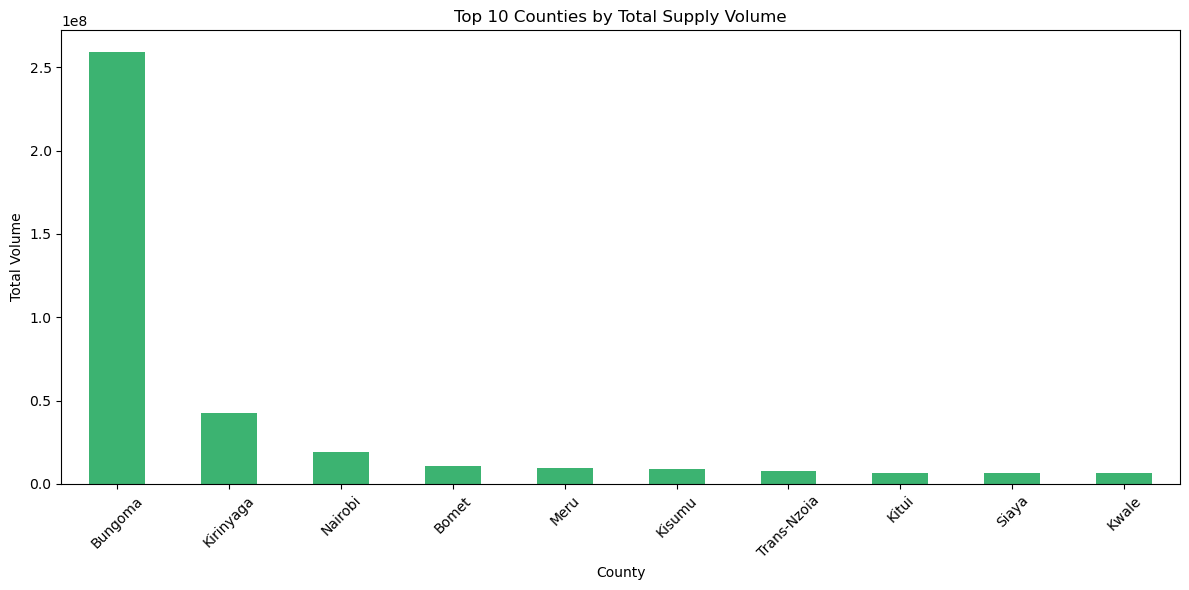

In [133]:
plt.figure(figsize=(12, 6))
tb.groupby('County')['Supply Volume'].sum().sort_values(ascending=False).head(10)\
    .plot(kind='bar', color='mediumseagreen')
plt.title('Top 10 Counties by Total Supply Volume')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

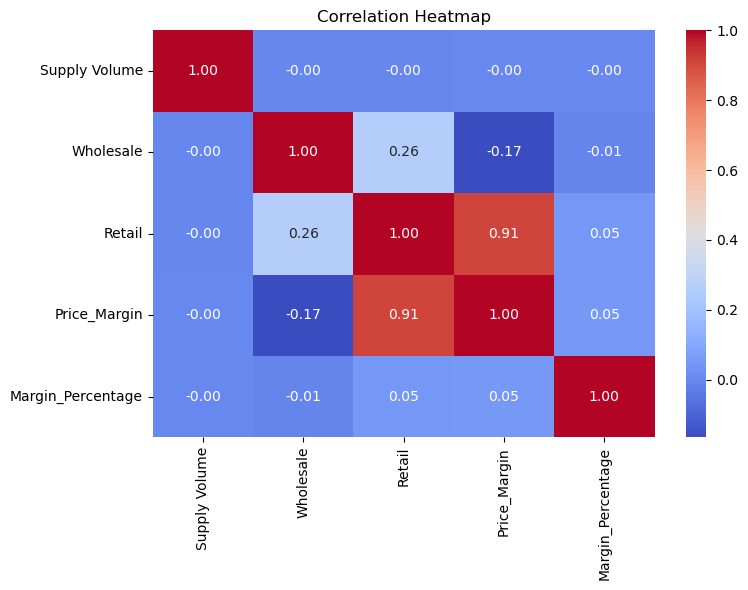

In [134]:
plt.figure(figsize=(8, 6))
corr = tb[['Supply Volume', 'Wholesale', 'Retail', 'Price_Margin', 'Margin_Percentage']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

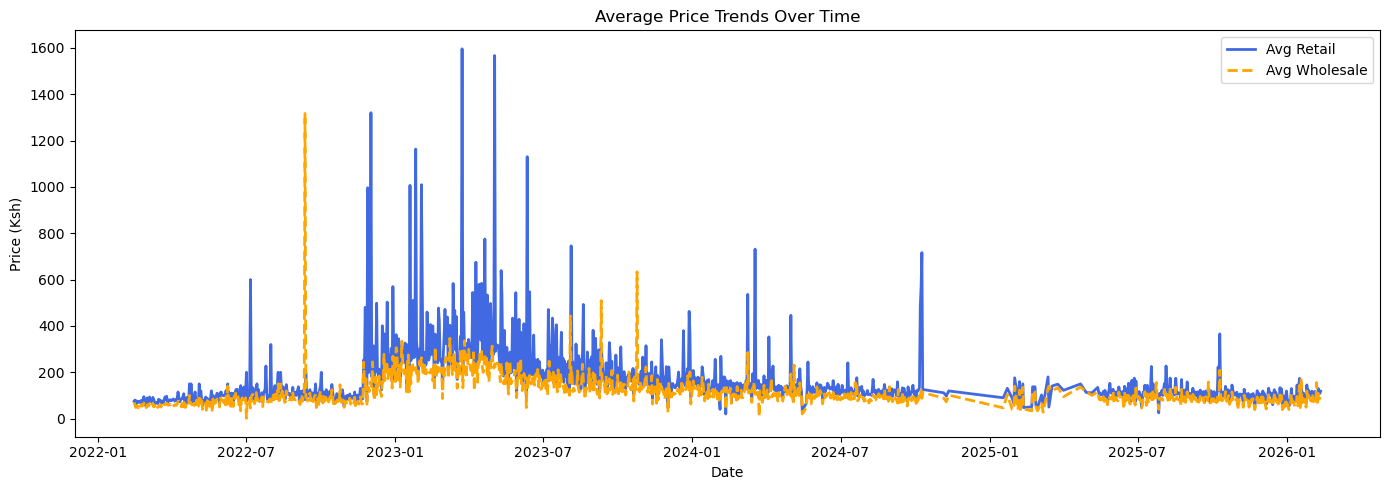

In [135]:
plt.figure(figsize=(14, 5))
market_trend = tb.groupby('Date')[['Retail', 'Wholesale']].mean()
plt.plot(market_trend.index, market_trend['Retail'],    label='Avg Retail',    color='royalblue', linewidth=2)
plt.plot(market_trend.index, market_trend['Wholesale'], label='Avg Wholesale', color='orange',    linewidth=2, linestyle='--')
plt.title('Average Price Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Price (Ksh)')
plt.legend()
plt.tight_layout()
plt.show()

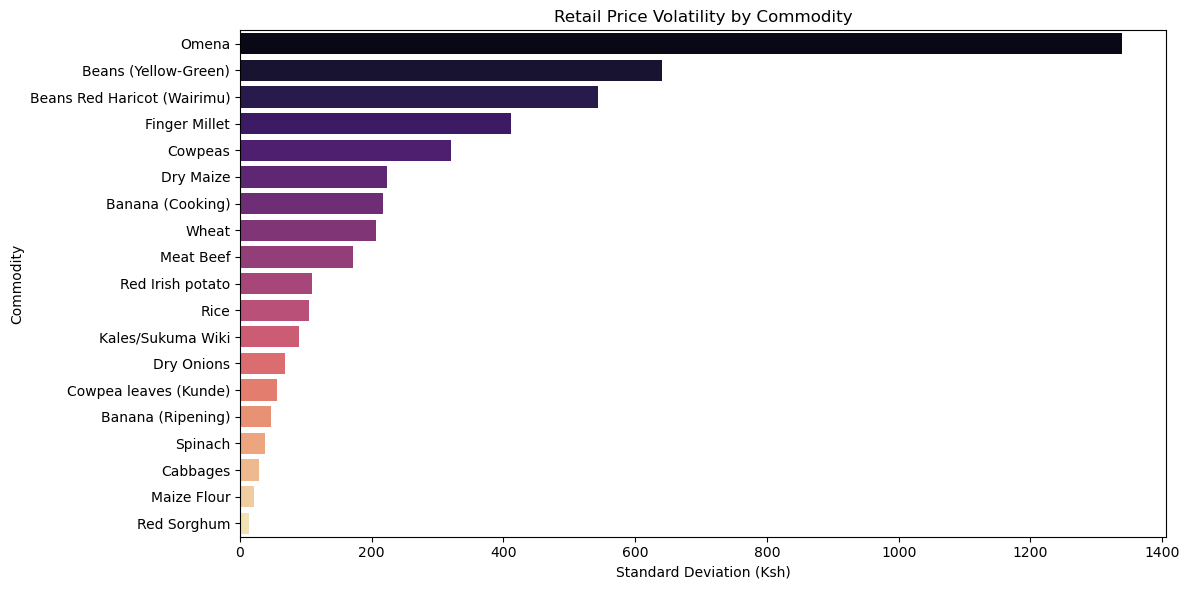

In [136]:
plt.figure(figsize=(12, 6))
volatility = tb.groupby('Commodity')['Retail'].std().sort_values(ascending=False)
sns.barplot(x=volatility.values, y=volatility.index, palette='magma')
plt.title('Retail Price Volatility by Commodity')
plt.xlabel('Standard Deviation (Ksh)')
plt.tight_layout()
plt.show()

In [137]:
COMMODITY      = 'Rice'  
SEQ_LENGTH     = 60      
FORECAST_STEPS = 30      
TEST_RATIO     = 0.2

ts = (
    tb[tb['Commodity'] == COMMODITY]
    .sort_values('Date')
    .groupby('Date')
    .agg(Retail=('Retail','mean'), Wholesale=('Wholesale','mean'), Supply_Volume=('Supply Volume','mean'))
    .resample('D').mean()
    .ffill()
    .bfill()
    .dropna()
)

print(f'Commodity  : {COMMODITY}')
print(f'Date range : {ts.index.min().date()} → {ts.index.max().date()}')
print(f'Total days : {len(ts)}')
ts.head()

Commodity  : Rice
Date range : 2024-04-18 → 2026-02-11
Total days : 665


,Retail,Wholesale,Supply_Volume
Date,,,
2024-04-18,162.000000,150.000000,2610.000000
2024-04-19,170.000000,147.388333,11116.666667
2024-04-20,160.000000,131.000000,4000.000000
2024-04-21,160.000000,131.000000,4000.000000
2024-04-22,157.142857,132.714286,4492.857143


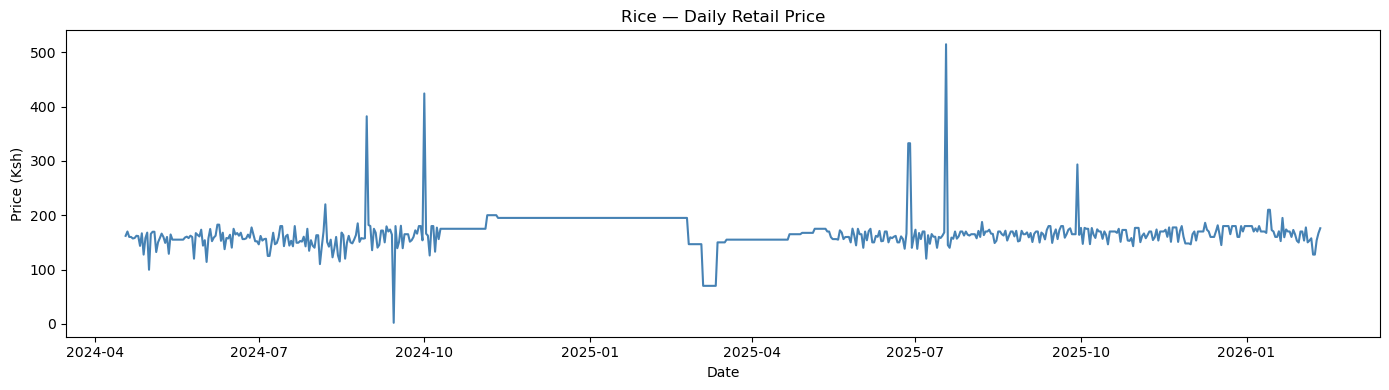

In [138]:
plt.figure(figsize=(14, 4))
plt.plot(ts.index, ts['Retail'], color='steelblue', linewidth=1.5)
plt.title('Rice — Daily Retail Price')
plt.xlabel('Date')
plt.ylabel('Price (Ksh)')
plt.tight_layout()
plt.show()

In [139]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(ts[['Retail']])

In [140]:
X_all, y_all = [], []
for i in range(len(scaled) - SEQ_LENGTH):
    X_all.append(scaled[i : i + SEQ_LENGTH])
    y_all.append(scaled[i + SEQ_LENGTH])

X_all = np.array(X_all)
y_all = np.array(y_all)

In [141]:
split = int(len(X_all) * (1 - TEST_RATIO))
X_train_lstm, X_test_lstm = X_all[:split], X_all[split:]
y_train_lstm, y_test_lstm = y_all[:split], y_all[split:]

print(f'X_train : {X_train_lstm.shape}')
print(f'X_test  : {X_test_lstm.shape}')

X_train : (484, 60, 1)
X_test  : (121, 60, 1)


In [142]:
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - loss: 0.0362 - mae: 0.1562 - val_loss: 0.0028 - val_mae: 0.0435 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0081 - mae: 0.0628 - val_loss: 0.0020 - val_mae: 0.0266 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0059 - mae: 0.0483 - val_loss: 0.0017 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0056 - mae: 0.0436 - val_loss: 0.0016 - val_mae: 0.0199 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0058 - mae: 0.0442 - val_loss: 0.0016 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0054 - mae: 0.0429 - val_loss: 0.0016 - val_mae: 0.0205 - learning_rate: 0.0010
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0051 - mae: 0.0434 - val_loss: 0.0019 - val_mae: 0.0277 - learning_rate: 0.0010
Epoch

In [144]:
lstm_preds = model_lstm.predict(X_test_lstm)
lstm_preds = scaler.inverse_transform(lstm_preds)
y_test_actual = scaler.inverse_transform(y_test_lstm)

lstm_mae  = mean_absolute_error(y_test_actual, lstm_preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_preds))
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_preds)

print(f'MAE  : {lstm_mae:.2f} Ksh')
print(f'RMSE : {lstm_rmse:.2f} Ksh')
print(f'MAPE : {lstm_mape*100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step
MAE  : 9.80 Ksh
RMSE : 12.43 Ksh
MAPE : 6.02%


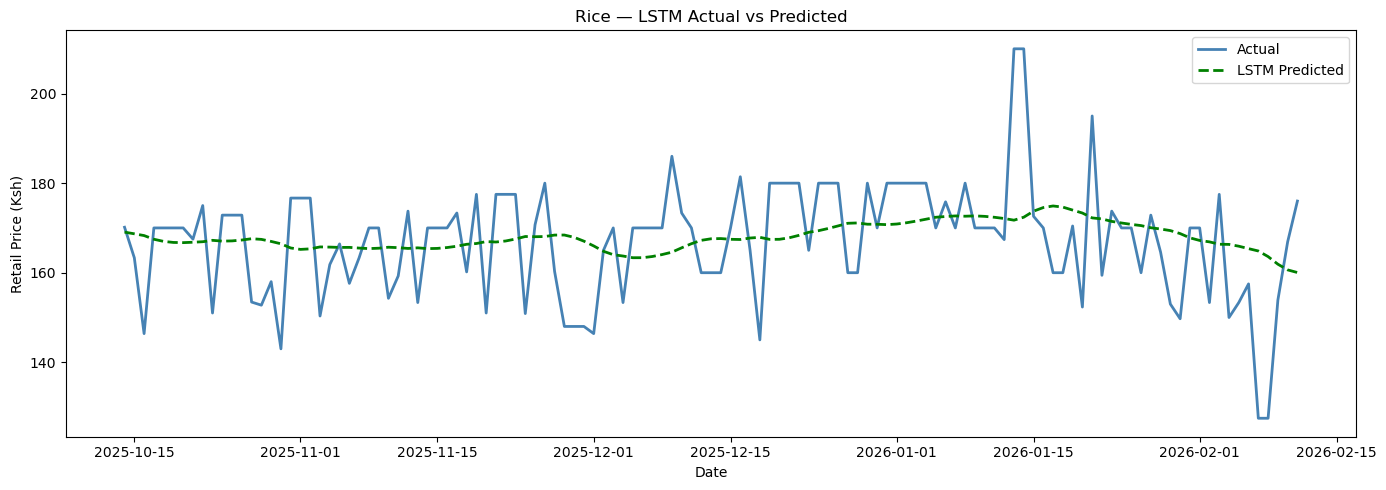

In [145]:
test_dates = ts.index[SEQ_LENGTH + int(len(X_all) * (1 - TEST_RATIO)):]

plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_actual, label='Actual',         color='steelblue', linewidth=2)
plt.plot(test_dates, lstm_preds,    label='LSTM Predicted', color='green',     linewidth=2, linestyle='--')
plt.title('Rice — LSTM Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Retail Price (Ksh)')
plt.legend()
plt.tight_layout()
plt.show()

In [146]:
tb_rice = ts.copy()

tb_rice['day_of_year'] = tb_rice.index.dayofyear
tb_rice['month']       = tb_rice.index.month
tb_rice['day_of_week'] = tb_rice.index.dayofweek
tb_rice['quarter']     = tb_rice.index.quarter

In [147]:
for lag in [1, 7, 14, 30]:
    tb_rice[f'lag_{lag}'] = tb_rice['Retail'].shift(lag)

In [148]:
for window in [7, 14, 30]:
    tb_rice[f'rolling_mean_{window}'] = tb_rice['Retail'].rolling(window).mean()
    tb_rice[f'rolling_std_{window}']  = tb_rice['Retail'].rolling(window).std()

tb_rice = tb_rice.dropna()
print(f'Features : {tb_rice.shape[1]}')
print(f'Rows     : {tb_rice.shape[0]}')

Features : 17
Rows     : 635


In [149]:
feature_cols = [c for c in tb_rice.columns if c != 'Retail']

X_xgb = tb_rice[feature_cols]
y_xgb = tb_rice['Retail']

split_xgb = int(len(X_xgb) * (1 - TEST_RATIO))
X_train_xgb, X_test_xgb = X_xgb.iloc[:split_xgb], X_xgb.iloc[split_xgb:]
y_train_xgb, y_test_xgb = y_xgb.iloc[:split_xgb], y_xgb.iloc[split_xgb:]

print(f'Train : {X_train_xgb.shape}')
print(f'Test  : {X_test_xgb.shape}')

Train : (508, 16)
Test  : (127, 16)


In [150]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train_xgb, y_train_xgb)
print('XGBoost training complete ')

XGBoost training complete 


In [151]:
xgb_preds = xgb_model.predict(X_test_xgb)

xgb_mae  = mean_absolute_error(y_test_xgb, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_preds))
xgb_mape = mean_absolute_percentage_error(y_test_xgb, xgb_preds)

print(f'MAE  : {xgb_mae:.2f} Ksh')
print(f'RMSE : {xgb_rmse:.2f} Ksh')
print(f'MAPE : {xgb_mape*100:.2f}%')

MAE  : 6.70 Ksh
RMSE : 8.36 Ksh
MAPE : 4.07%


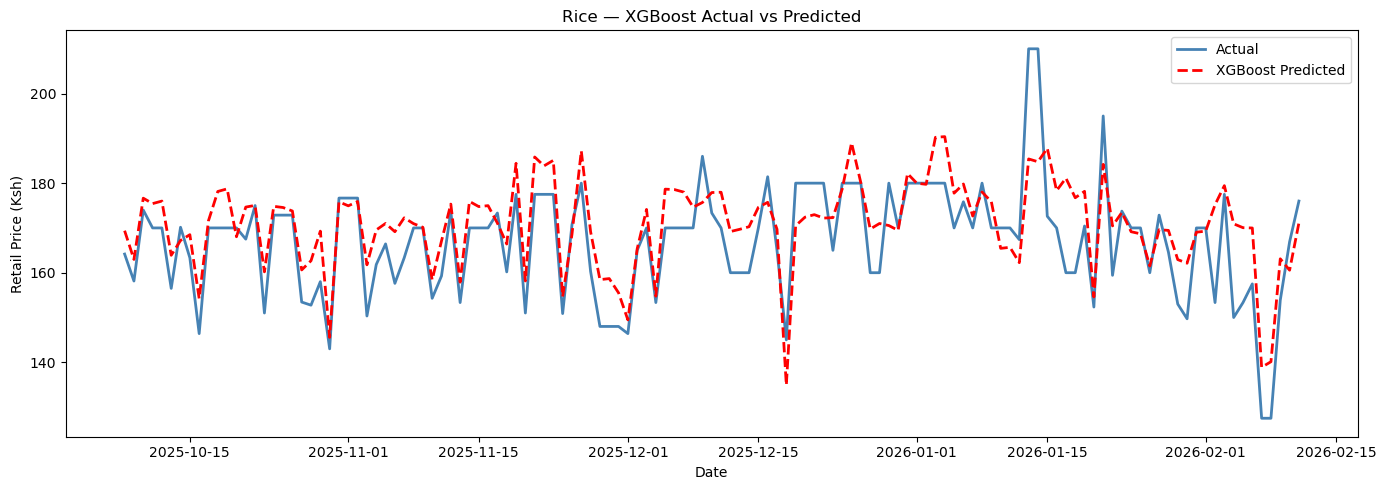

In [152]:
plt.figure(figsize=(14, 5))
plt.plot(X_test_xgb.index, y_test_xgb.values, label='Actual',            color='steelblue', linewidth=2)
plt.plot(X_test_xgb.index, xgb_preds,          label='XGBoost Predicted', color='red',       linewidth=2, linestyle='--')
plt.title('Rice — XGBoost Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Retail Price (Ksh)')
plt.legend()
plt.tight_layout()
plt.show()

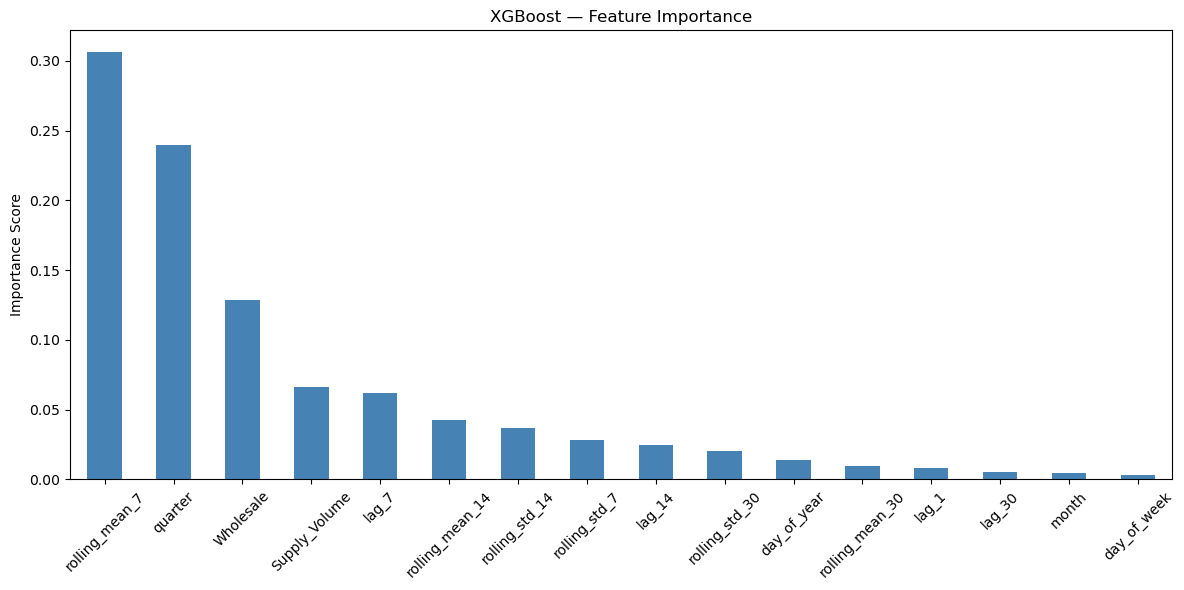

In [153]:
plt.figure(figsize=(12, 6))
importance = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
importance.plot(kind='bar', color='steelblue')
plt.title('XGBoost — Feature Importance')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [154]:
comparison = pd.DataFrame({
    'Model': ['LSTM', 'XGBoost'],
    'MAE':   [lstm_mae,  xgb_mae],
    'RMSE':  [lstm_rmse, xgb_rmse],
    'MAPE':  [lstm_mape * 100, xgb_mape * 100]
}).set_index('Model')

print(comparison)

              MAE       RMSE      MAPE
Model                                 
LSTM     9.798483  12.429079  6.020364
XGBoost  6.698235   8.360825  4.072977


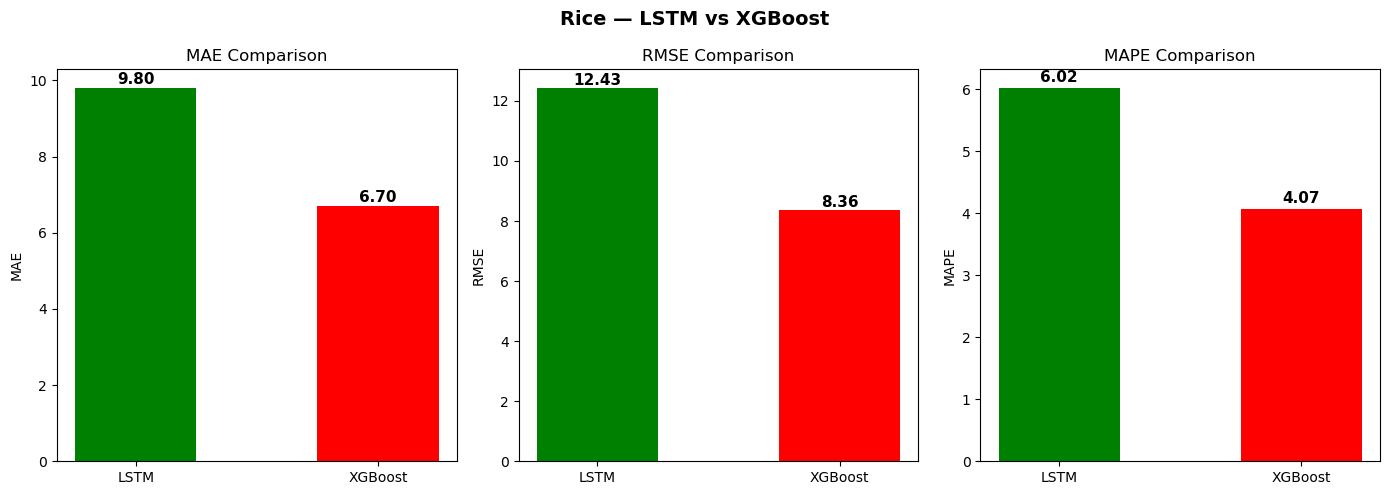

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for ax, metric in zip(axes, ['MAE', 'RMSE', 'MAPE']):
    bars = ax.bar(comparison.index, comparison[metric], color=['green', 'red'], width=0.5)
    for bar, val in zip(bars, comparison[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{val:.2f}', ha='center', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)

plt.suptitle('Rice — LSTM vs XGBoost', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [156]:
last_data = tb_rice.copy()
future_dates = pd.date_range(ts.index[-1] + pd.Timedelta(days=1), periods=FORECAST_STEPS, freq='D')
future_preds = []

for date in future_dates:
    # build features from last row
    last_row = last_data[feature_cols].iloc[[-1]]
    pred = xgb_model.predict(last_row)[0]
    future_preds.append(pred)

    # create new row with updated values
    new_row = pd.DataFrame(index=[date], columns=last_data.columns)
    new_row['Retail'] = pred
    new_row['Wholesale']     = last_data['Wholesale'].iloc[-1]
    new_row['Supply_Volume'] = last_data['Supply_Volume'].iloc[-1]
    new_row['day_of_year']   = date.dayofyear
    new_row['month']         = date.month
    new_row['day_of_week']   = date.dayofweek
    new_row['quarter']       = date.quarter

    last_data = pd.concat([last_data, new_row])

    for lag in [1, 7, 14, 30]:
        last_data.loc[date, f'lag_{lag}'] = last_data['Retail'].shift(lag).iloc[-1]
    for window in [7, 14, 30]:
        last_data.loc[date, f'rolling_mean_{window}'] = last_data['Retail'].rolling(window).mean().iloc[-1]
        last_data.loc[date, f'rolling_std_{window}']  = last_data['Retail'].rolling(window).std().iloc[-1]

print(f'Forecast done — {len(future_preds)} days predicted')
print(future_preds)

Forecast done — 30 days predicted
[np.float32(171.1254), np.float32(173.76048), np.float32(173.46643), np.float32(174.87119), np.float32(172.60455), np.float32(174.92712), np.float32(171.92897), np.float32(173.66936), np.float32(170.6309), np.float32(173.7756), np.float32(173.22432), np.float32(173.066), np.float32(168.28244), np.float32(170.00618), np.float32(169.8386), np.float32(170.70143), np.float32(169.90208), np.float32(169.55014), np.float32(169.28258), np.float32(166.74164), np.float32(169.62996), np.float32(169.21347), np.float32(170.96066), np.float32(168.88394), np.float32(168.71506), np.float32(168.42828), np.float32(166.24435), np.float32(167.38669), np.float32(167.8085), np.float32(167.34888)]


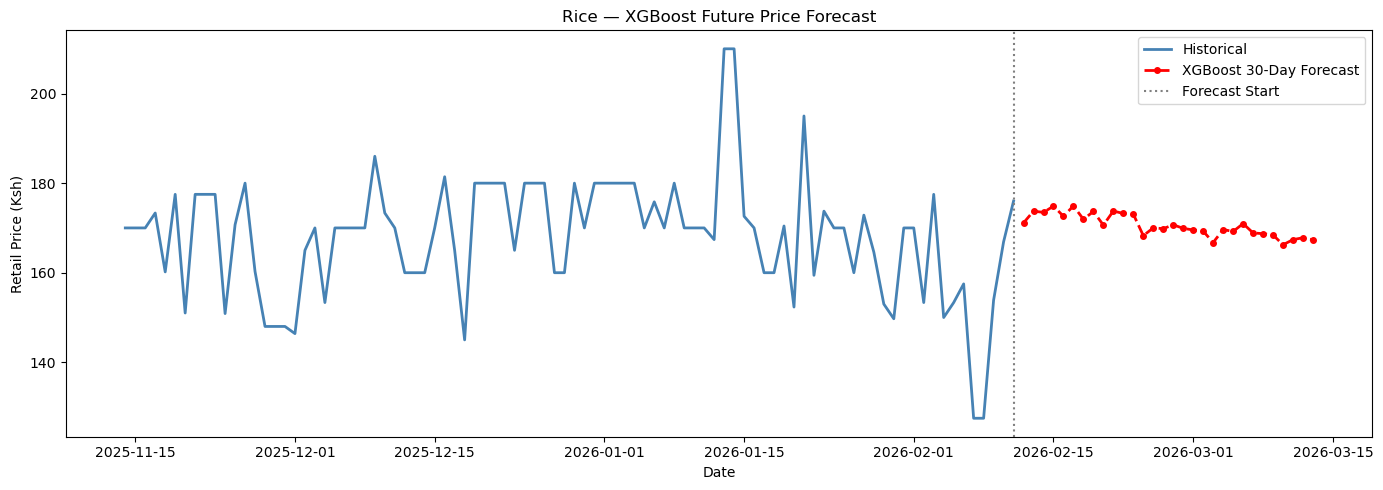

In [157]:
plt.figure(figsize=(14, 5))
plt.plot(ts.index[-90:], ts['Retail'].iloc[-90:], label='Historical', color='steelblue', linewidth=2)
plt.plot(future_dates, future_preds, label=f'XGBoost {FORECAST_STEPS}-Day Forecast', color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.axvline(ts.index[-1], color='grey', linestyle=':', linewidth=1.5, label='Forecast Start')
plt.title('Rice — XGBoost Future Price Forecast')
plt.xlabel('Date')
plt.ylabel('Retail Price (Ksh)')
plt.legend()
plt.tight_layout()
plt.show()

In [158]:
last_seq = scaled[-SEQ_LENGTH:]
lstm_future_preds = []

In [159]:
for _ in range(FORECAST_STEPS):
    inp  = last_seq.reshape(1, SEQ_LENGTH, 1)
    pred = model_lstm.predict(inp, verbose=0)[0, 0]
    lstm_future_preds.append(pred)
    last_seq = np.append(last_seq[1:], [[pred]], axis=0)

In [160]:
lstm_future_preds = scaler.inverse_transform(np.array(lstm_future_preds).reshape(-1, 1)).flatten()

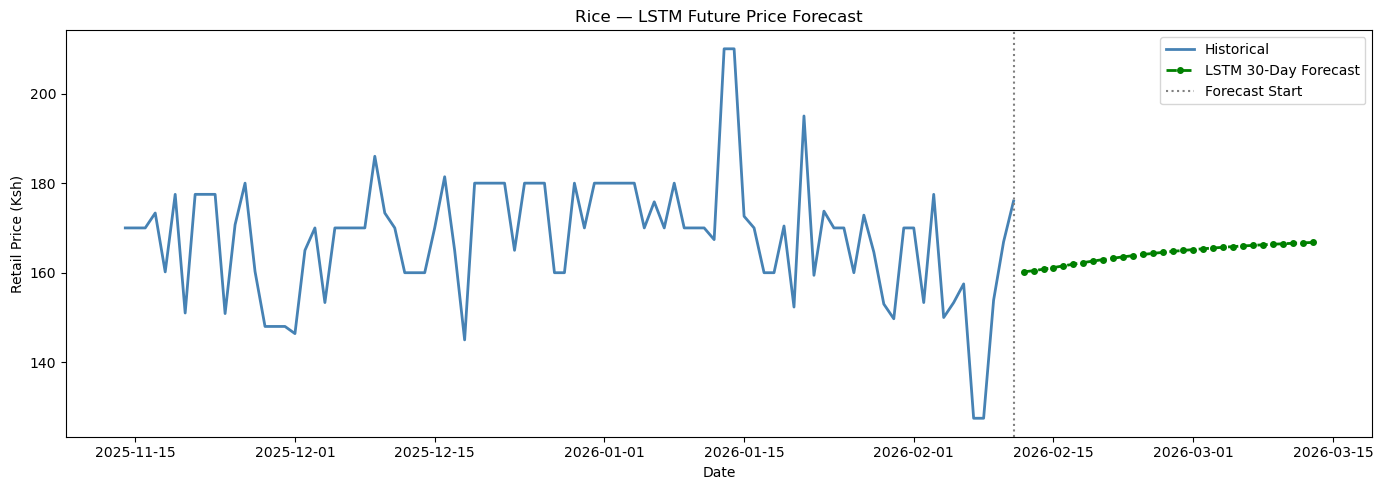

In [161]:
plt.figure(figsize=(14, 5))
plt.plot(ts.index[-90:], ts['Retail'].iloc[-90:], label='Historical', color='steelblue', linewidth=2)
plt.plot(future_dates, lstm_future_preds, label=f'LSTM {FORECAST_STEPS}-Day Forecast', color='green', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.axvline(ts.index[-1], color='grey', linestyle=':', linewidth=1.5, label='Forecast Start')
plt.title('Rice — LSTM Future Price Forecast')
plt.xlabel('Date')
plt.ylabel('Retail Price (Ksh)')
plt.legend()
plt.tight_layout()
plt.show()

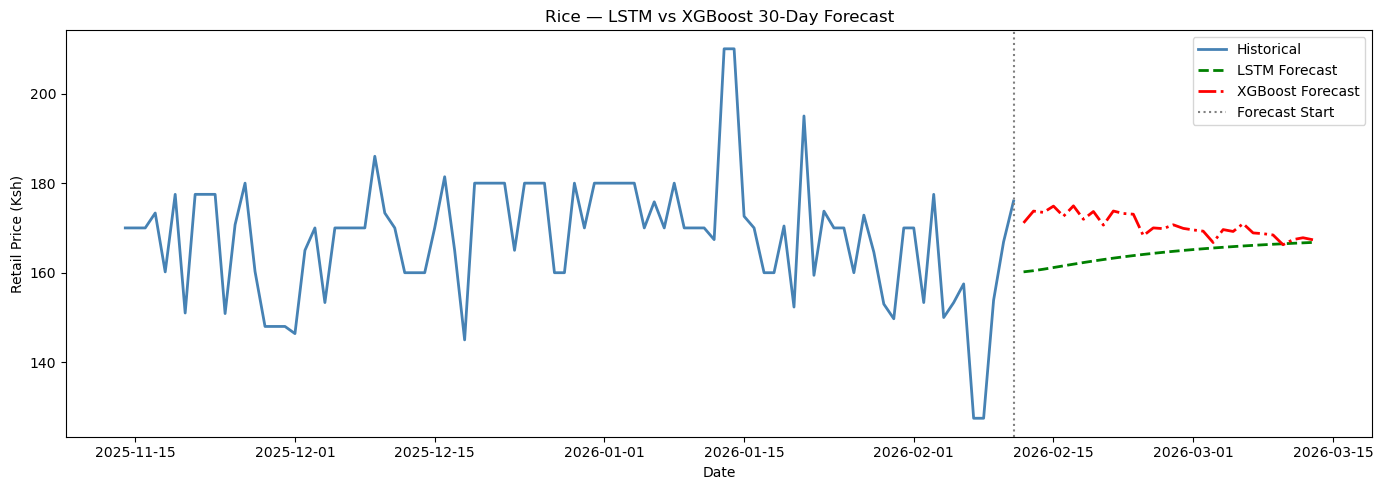

In [162]:
plt.figure(figsize=(14, 5))
plt.plot(ts.index[-90:], ts['Retail'].iloc[-90:], label='Historical', color='steelblue', linewidth=2)
plt.plot(future_dates, lstm_future_preds, label='LSTM Forecast',    color='green', linewidth=2, linestyle='--')
plt.plot(future_dates, future_preds,      label='XGBoost Forecast', color='red',   linewidth=2, linestyle='-.')
plt.axvline(ts.index[-1], color='grey', linestyle=':', linewidth=1.5, label='Forecast Start')
plt.title('Rice — LSTM vs XGBoost 30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Retail Price (Ksh)')
plt.legend()
plt.tight_layout()
plt.show()

In [163]:
commodities = tb['Commodity'].unique()
results = []

In [165]:
print(tb['Commodity'].unique())
print(f'Total: {len(tb["Commodity"].unique())}')

['Banana (Ripening)' 'Beans Red Haricot (Wairimu)' 'Meat Beef' 'Cabbages'
 'Banana (Cooking)' 'Cowpeas' 'Cowpea leaves (Kunde)' 'Dry Maize'
 'Dry Onions' 'Finger Millet' 'Maize Flour' 'Kales/Sukuma Wiki' 'Omena'
 'Red Irish potato' 'Red Sorghum' 'Rice' 'Spinach' 'Wheat'
 'Beans (Yellow-Green)']
Total: 19


In [164]:
for COMMODITY in commodities:
    print(f'\nTraining: {COMMODITY}')
    
    ts = (
        tb[tb['Commodity'] == COMMODITY]
        .sort_values('Date')
        .groupby('Date')
        .agg(Retail=('Retail','mean'), Wholesale=('Wholesale','mean'), Supply_Volume=('Supply Volume','mean'))
        .resample('D').mean().ffill().bfill().dropna()
    )
    
    if len(ts) < SEQ_LENGTH + 50:
        print(f'  Skipping {COMMODITY} — not enough data')
        continue


Training: Banana (Ripening)

Training: Beans Red Haricot (Wairimu)

Training: Meat Beef

Training: Cabbages

Training: Banana (Cooking)

Training: Cowpeas

Training: Cowpea leaves (Kunde)

Training: Dry Maize

Training: Dry Onions

Training: Finger Millet

Training: Maize Flour

Training: Kales/Sukuma Wiki

Training: Omena

Training: Red Irish potato

Training: Red Sorghum
  Skipping Red Sorghum — not enough data

Training: Rice

Training: Spinach

Training: Wheat

Training: Beans (Yellow-Green)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(ts[['Retail']])
    
X_all, y_all = [], []
for i in range(len(scaled) - SEQ_LENGTH):
        X_all.append(scaled[i : i + SEQ_LENGTH])
        y_all.append(scaled[i + SEQ_LENGTH])
X_all = np.array(X_all)
y_all = np.array(y_all)
    
split = int(len(X_all) * (1 - TEST_RATIO))
X_train_lstm, X_test_lstm = X_all[:split], X_all[split:]
y_train_lstm, y_test_lstm = y_all[:split], y_all[split:]

In [166]:
from sklearn.model_selection import GridSearchCV

In [167]:
param_grid = {
    'n_estimators':  [100, 300, 500],
    'max_depth':     [3, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample':     [0.7, 0.8, 1.0]
}

xgb_tune = xgb.XGBRegressor(random_state=42, verbosity=0)

search = GridSearchCV(xgb_tune, param_grid, scoring='neg_mean_absolute_error',
                      cv=3, verbose=1, n_jobs=-1)

search.fit(X_train_xgb, y_train_xgb)

print(f'Best params : {search.best_params_}')
print(f'Best MAE    : {-search.best_score_:.2f} Ksh')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best params : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Best MAE    : 9.40 Ksh
